In [2]:
import os
import glob

# Ganti dengan path ke folder Anda
folder_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/"
file_format_to_delete = "*.db" # Pola untuk file .db

# Membuat path lengkap untuk pola pencarian
search_pattern = os.path.join(folder_path, file_format_to_delete)

# Mencari semua file yang cocok dengan pola
db_files = glob.glob(search_pattern)

if not db_files:
    print(f"Tidak ada file {file_format_to_delete} yang ditemukan di '{folder_path}'.")
else:
    print(f"File .db yang akan dihapus di '{folder_path}':")
    for file_path in db_files:
        print(file_path)
    
    # Konfirmasi sebelum menghapus
    konfirmasi = input("Apakah Anda yakin ingin menghapus file-file ini? (ya/tidak): ").strip().lower()
    
    if konfirmasi == 'ya':
        for file_path in db_files:
            try:
                os.remove(file_path)
                print(f"Berhasil menghapus: {file_path}")
            except OSError as e:
                print(f"Error saat menghapus {file_path}: {e.strerror}")
        print("Proses penghapusan selesai.")
    else:
        print("Penghapusan dibatalkan.")

File .db yang akan dihapus di '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/':
/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/Thumbs.db


Apakah Anda yakin ingin menghapus file-file ini? (ya/tidak):  ya


Error saat menghapus /kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/Thumbs.db: Read-only file system
Proses penghapusan selesai.


In [3]:
import os
import shutil # Untuk menyalin file nanti (opsional, jika ingin membuat struktur folder train/val/test)
import random # Untuk pembagian data
import numpy as np
import pandas as pd # Berguna untuk manajemen daftar file
from PIL import Image # Untuk memuat gambar
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from transformers import ViTImageProcessor, ViTForImageClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

2025-05-30 17:18:24.233394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748625504.415599      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748625504.469118      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. KONFIGURASI

In [4]:
MODEL_NAME = "google/vit-base-patch16-224"
NUM_CLASSES = 2  # Parasitized dan Uninfected
BATCH_SIZE = 32 # Sesuaikan dengan VRAM Kaggle (P100/T4 biasanya bisa batch 32-64)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50 # Jumlah epoch bisa ditambah karena ada early stopping
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path dataset di Kaggle
BASE_DATA_DIR = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/"
PARASITIZED_DIR = os.path.join(BASE_DATA_DIR, "Parasitized")
UNINFECTED_DIR = os.path.join(BASE_DATA_DIR, "Uninfected")

MODEL_SAVE_PATH = "/kaggle/working/best_vit_malaria_model.pth"

# Konfigurasi Early Stopping
PATIENCE_EARLY_STOPPING = 5
DELTA_EARLY_STOPPING = 0.001 # Akurasi harus meningkat minimal 0.1%

print(f"Menggunakan device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Jumlah kelas: {NUM_CLASSES}")
print(f"Path model akan disimpan di: {MODEL_SAVE_PATH}")
print(f"Early Stopping Patience: {PATIENCE_EARLY_STOPPING}, Min Delta: {DELTA_EARLY_STOPPING}")

# --- Kelas EarlyStopping (sama seperti sebelumnya) ---
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0, path='checkpoint.pt', trace_func=print, mode='max'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_at_best_score = -np.Inf if mode == 'max' else np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.mode = mode
        self.best_model_wts = None

    def __call__(self, val_metric, model):
        score = val_metric
        is_improvement = False
        if self.mode == 'max':
            if score > self.val_metric_at_best_score + self.delta:
                is_improvement = True
        else:
            if score < self.val_metric_at_best_score - self.delta:
                is_improvement = True

        if self.best_score is None:
            self.best_score = score
            if is_improvement or self.val_metric_at_best_score == (-np.Inf if self.mode == 'max' else np.Inf):
                 self.val_metric_at_best_score = score
                 self.save_checkpoint(val_metric, model)
        elif is_improvement:
            if self.verbose:
                self.trace_func(f'Validation metric ({self.mode}) improved ({self.val_metric_at_best_score:.6f} --> {score:.6f}). Menyimpan model ke {self.path} ...')
            self.best_score = score
            self.val_metric_at_best_score = score
            self.save_checkpoint(val_metric, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} dari {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_metric, model):
        self.best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(self.best_model_wts, self.path)

Menggunakan device: cuda
Model: google/vit-base-patch16-224
Jumlah kelas: 2
Path model akan disimpan di: /kaggle/working/best_vit_malaria_model.pth
Early Stopping Patience: 5, Min Delta: 0.001


# 2. MEMUAT IMAGE PROCESSOR DAN MODEL

In [5]:
try:
    image_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True # Penting jika mengganti head klasifikasi
    )
    model.to(DEVICE)
except Exception as e:
    print(f"Error saat memuat model atau processor: {e}")
    print("Pastikan Anda memiliki koneksi internet (di Kaggle, aktifkan di Settings).")
    # exit() # Sebaiknya jangan exit di notebook, biarkan error muncul

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 3. PERSIAPAN DATA

In [6]:
# Mendapatkan daftar semua file gambar dan labelnya
parasitized_files = [os.path.join(PARASITIZED_DIR, f) for f in os.listdir(PARASITIZED_DIR) if f.endswith('.png')]
uninfected_files = [os.path.join(UNINFECTED_DIR, f) for f in os.listdir(UNINFECTED_DIR) if f.endswith('.png')]

# Label: 0 untuk Parasitized, 1 untuk Uninfected (atau sebaliknya, pastikan konsisten)
# Mari kita gunakan: Parasitized = 0, Uninfected = 1
# Jika menggunakan ImageFolder, urutan kelas biasanya alfabetis.
# Di sini kita kontrol manual, jadi lebih fleksibel.
# Kelas yang diharapkan oleh model (jika ImageFolder): {'Parasitized': 0, 'Uninfected': 1}
# Kita akan buat label: Parasitized = 0, Uninfected = 1
labels_parasitized = [0] * len(parasitized_files)
labels_uninfected = [1] * len(uninfected_files)

all_files = parasitized_files + uninfected_files
all_labels = labels_parasitized + labels_uninfected

# Pembagian data: 80% train, 10% validation, 10% test
# Pertama, bagi menjadi train dan temp (val+test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)
# Kemudian, bagi temp menjadi validation dan test
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42 # 0.5 dari 0.2 = 0.1
)

print(f"Jumlah data train: {len(train_files)}")
print(f"Jumlah data validation: {len(val_files)}")
print(f"Jumlah data test: {len(test_files)}")
print(f"Contoh file train: {train_files[0]}, Label: {train_labels[0]}")

# --- Dataset Kustom PyTorch ---
class MalariaDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        # Tentukan class_to_idx agar konsisten dengan apa yang mungkin dihasilkan ImageFolder
        self.class_to_idx = {'Parasitized': 0, 'Uninfected': 1}
        self.classes = ['Parasitized', 'Uninfected']


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB") # Pastikan RGB
        except FileNotFoundError:
            print(f"Error: File tidak ditemukan di {img_path}")
            # Kembalikan dummy data atau raise error
            # Untuk sekarang, kita raise error agar masalah diketahui
            raise FileNotFoundError(f"File tidak ditemukan {img_path}")
        except Exception as e:
            print(f"Error saat memuat gambar {img_path}: {e}")
            # Kembalikan dummy data atau raise error
            raise e


        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Transformasi Data (sama seperti sebelumnya) ---
def vit_core_processor_transform(pil_image, processor):
    # image_processor sudah menghandle konversi ke RGB jika inputnya PIL Image
    # dan parameternya do_convert_rgb=True (default)
    # return processor(images=pil_image, return_tensors='pt')['pixel_values'].squeeze(0) # squeeze(0) jika batch_size=1
    # Jika dipanggil dari transform di Dataset, yang diproses satu gambar, maka squeeze(0) benar.
    # Untuk ViTImageProcessor, dia bisa handle PIL image langsung.
    processed_output = processor(images=pil_image, return_tensors='pt')
    return processed_output['pixel_values'].squeeze(0)


try:
    if isinstance(image_processor.size, dict):
        if 'height' in image_processor.size and 'width' in image_processor.size:
            target_size = (image_processor.size['height'], image_processor.size['width'])
        elif 'shortest_edge' in image_processor.size:
            s_edge = image_processor.size['shortest_edge']
            target_size = (s_edge, s_edge)
        else: target_size = (224, 224) # Fallback
    elif isinstance(image_processor.size, int): target_size = (image_processor.size, image_processor.size)
    else: target_size = (224, 224) # Fallback
except AttributeError: target_size = (224, 224) # Fallback
except Exception: target_size = (224, 224) # Fallback

print(f"Target size untuk augmentasi (RandomResizedCrop): {target_size}")

train_transforms = T.Compose([
    T.RandomResizedCrop(target_size, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    T.RandomRotation(degrees=20), # Tingkatkan sedikit rotasi
    T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.12), # Tingkatkan sedikit jitter
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(), # Tambahkan vertical flip, bisa relevan untuk sel
    lambda img: vit_core_processor_transform(img, image_processor)
])

val_test_transforms = T.Compose([
    # ViTImageProcessor akan menangani resize ke target_size yang sesuai konfigurasinya
    lambda img: vit_core_processor_transform(img, image_processor)
])

# Membuat instance Dataset
train_dataset = MalariaDataset(train_files, train_labels, transform=train_transforms)
val_dataset = MalariaDataset(val_files, val_labels, transform=val_test_transforms)
test_dataset = MalariaDataset(test_files, test_labels, transform=val_test_transforms)

# Membuat DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers=2 standar di Kaggle
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Jumlah batch di train_loader: {len(train_loader)}")
print(f"Contoh data dari train_loader (1 batch):")
try:
    sample_images, sample_labels = next(iter(train_loader))
    print(f"Bentuk tensor gambar: {sample_images.shape}, Bentuk tensor label: {sample_labels.shape}")
except Exception as e:
    print(f"Error saat mengambil sampel dari train_loader: {e}")

Jumlah data train: 22046
Jumlah data validation: 2756
Jumlah data test: 2756
Contoh file train: /kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C172P133ThinF_IMG_20151119_155343_cell_287.png, Label: 0
Target size untuk augmentasi (RandomResizedCrop): (224, 224)
Jumlah batch di train_loader: 689
Contoh data dari train_loader (1 batch):
Bentuk tensor gambar: torch.Size([32, 3, 224, 224]), Bentuk tensor label: torch.Size([32])


# 4. TRAINING

In [7]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

early_stopper = EarlyStopping(
    patience=PATIENCE_EARLY_STOPPING,
    verbose=True,
    delta=DELTA_EARLY_STOPPING,
    path=MODEL_SAVE_PATH,
    mode='max'
)

print("\nMemulai Training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_train_loss = 0.0
    train_preds_all, train_labels_all = [], []
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(logits, 1)
        train_preds_all.extend(preds.cpu().numpy())
        train_labels_all.extend(labels.cpu().numpy())
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_accuracy = accuracy_score(train_labels_all, train_preds_all)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    running_val_loss = 0.0
    val_preds_all, val_labels_all = [], []
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validasi]")
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(pixel_values=inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(logits, 1)
            val_preds_all.extend(preds.cpu().numpy())
            val_labels_all.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = accuracy_score(val_labels_all, val_preds_all)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    early_stopper(epoch_val_accuracy, model)
    if early_stopper.early_stop:
        print("Early stopping dipicu.")
        break

print("Training Selesai.")


Memulai Training...


Epoch 1/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 1/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 0.1666, Train Acc: 0.9483 - Val Loss: 0.2264, Val Acc: 0.9369


Epoch 2/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 2/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.1991, Train Acc: 0.9419 - Val Loss: 0.1757, Val Acc: 0.9488
Validation metric (max) improved (0.936865 --> 0.948839). Menyimpan model ke /kaggle/working/best_vit_malaria_model.pth ...


Epoch 3/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 3/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.2031, Train Acc: 0.9407 - Val Loss: 0.1700, Val Acc: 0.9514
Validation metric (max) improved (0.948839 --> 0.951379). Menyimpan model ke /kaggle/working/best_vit_malaria_model.pth ...


Epoch 4/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 4/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.6516, Train Acc: 0.5683 - Val Loss: 0.6580, Val Acc: 0.6517
EarlyStopping counter: 1 dari 5


Epoch 5/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 5/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.5576, Train Acc: 0.6827 - Val Loss: 0.1906, Val Acc: 0.9376
EarlyStopping counter: 2 dari 5


Epoch 6/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 6/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.2099, Train Acc: 0.9351 - Val Loss: 0.1766, Val Acc: 0.9448
EarlyStopping counter: 3 dari 5


Epoch 7/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 7/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.1939, Train Acc: 0.9399 - Val Loss: 0.1694, Val Acc: 0.9445
EarlyStopping counter: 4 dari 5


Epoch 8/50 [Training]:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 8/50 [Validasi]:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.1911, Train Acc: 0.9402 - Val Loss: 0.1734, Val Acc: 0.9481
EarlyStopping counter: 5 dari 5
Early stopping dipicu.
Training Selesai.


# 5. VISUALISASI HASIL TRAINING

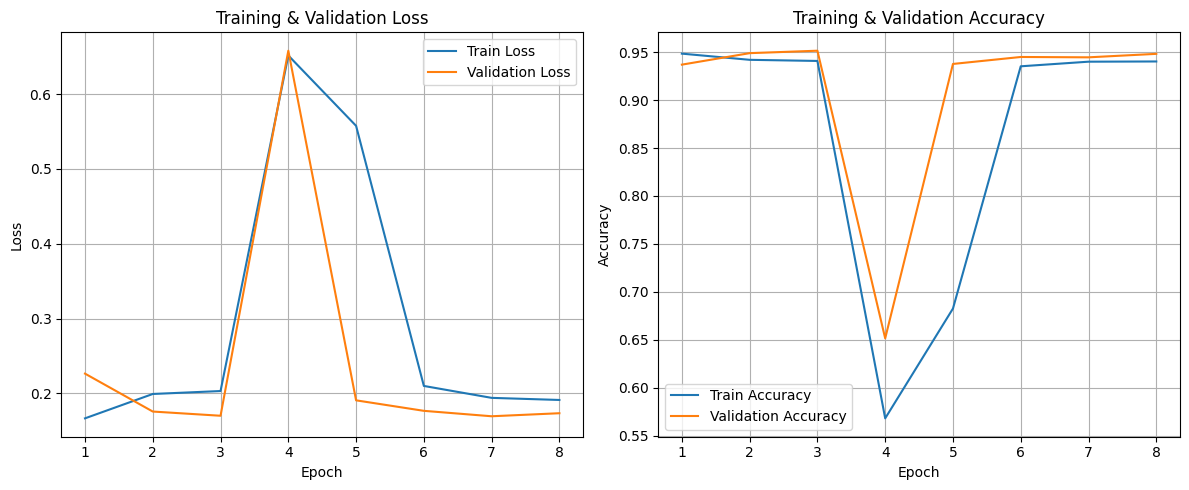

In [8]:
actual_epochs = len(train_losses)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, actual_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, actual_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# 6. EVALUASI PADA TEST SET


Memulai Evaluasi pada Test Set...
Model terbaik dimuat dari /kaggle/working/best_vit_malaria_model.pth untuk evaluasi.


Evaluasi Test Set:   0%|          | 0/87 [00:00<?, ?it/s]


Test Accuracy: 0.9543

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.95      1378
  Uninfected       0.95      0.96      0.95      1378

    accuracy                           0.95      2756
   macro avg       0.95      0.95      0.95      2756
weighted avg       0.95      0.95      0.95      2756


Confusion Matrix:


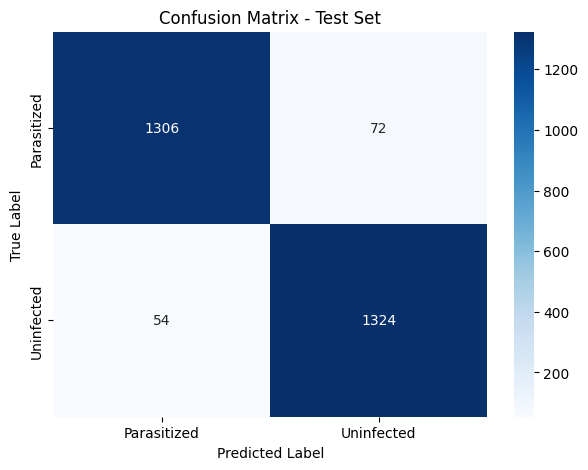


Selesai.


In [9]:
print("\nMemulai Evaluasi pada Test Set...")
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Model terbaik dimuat dari {MODEL_SAVE_PATH} untuk evaluasi.")
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
else:
    print(f"Tidak ada model yang disimpan di {MODEL_SAVE_PATH}. Menggunakan model dari state terakhir.")

model.eval()
test_preds_all, test_labels_all = [], []
test_pbar = tqdm(test_loader, desc="Evaluasi Test Set")
with torch.no_grad():
    for inputs, labels in test_pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(pixel_values=inputs)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)
        test_preds_all.extend(preds.cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds_all)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Nama kelas dari dataset kustom kita
class_names = test_dataset.classes # ['Parasitized', 'Uninfected']
print("\nClassification Report:")
try:
    report = classification_report(test_labels_all, test_preds_all, target_names=class_names, zero_division=0)
    print(report)
except Exception as e:
    print(f"Error membuat classification report: {e}")
    report = classification_report(test_labels_all, test_preds_all, zero_division=0) # Coba tanpa target_names
    print(report)


print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels_all, test_preds_all)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix - Test Set')
plt.show()

print("\nSelesai.")